In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
#Reading data
GME = pd.read_csv("GME.csv")

In [3]:
GME.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-21,4.75,4.75,4.55,4.59,4.59,3532100
1,2020-01-22,4.55,4.64,4.46,4.56,4.56,2627500
2,2020-01-23,4.55,4.64,4.46,4.62,4.62,1880200
3,2020-01-24,4.64,4.64,4.25,4.32,4.32,4163600
4,2020-01-27,4.20,4.35,4.16,4.28,4.28,2122500


*Note:* we only need the Date and Close columns

In [4]:
GME = GME[['Date', 'Close']]

In [5]:
GME.head()

,Date,Close
0,2020-01-21,4.59
1,2020-01-22,4.56
2,2020-01-23,4.62
3,2020-01-24,4.32
4,2020-01-27,4.28


In [6]:
GME.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 2 columns):
Date     257 non-null object
Close    257 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [7]:
#Converting date column into datetime 
GME.Time = pd.to_datetime(GME.Date, format = '%Y/%m/%d')

E:\Prog\Anaconda2019\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


## Plot of the GME stock price dataset

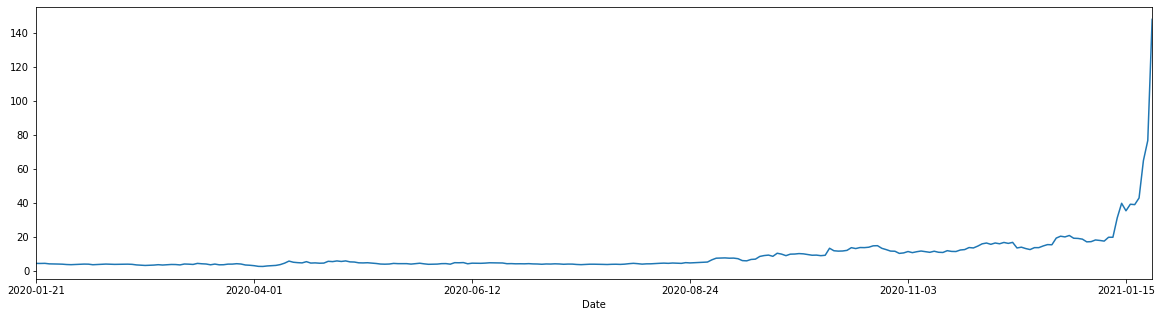

In [8]:
plot_GME = GME.set_index('Date')
plot_GME['Close'].plot(figsize=(20,5));

## Some Preprocessing

In [9]:
new_GME = GME.copy()

In [10]:
new_GME.tail()

,Date,Close
252,2021-01-20,39.119999
253,2021-01-21,43.029999
254,2021-01-22,65.010002
255,2021-01-25,76.790001
256,2021-01-26,147.979996


In [11]:
print(new_GME.isnull().sum())

Date     0
Close    0
dtype: int64


In [12]:
new_GME = new_GME.drop('Date', axis=1)
new_GME = new_GME.reset_index(drop=True)

In [13]:
new_GME.head()

,Close
0,4.59
1,4.56
2,4.62
3,4.32
4,4.28


In [14]:
T = new_GME.values
T = T.astype('float32')

In [15]:
T = T[~np.isnan(T)]
T = np.reshape(T, (-1, 1))

## Min-max Scaling

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
T = scaler.fit_transform(T)

## Test/Train split

In [17]:
train_size = int(len(T)*0.8)
test_size = int(len(T)-train_size)
train = T[0:train_size, :]
test = T[train_size: , :]

In [18]:
#Method for creating features for the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [19]:
#Assuming 5 trading days per week
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

#Reshaping to the format of [samples, time steps, features] (the format that lstm needs)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [20]:
#To check for a data leak
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T.shape, train.shape, test.shape))

False


## Building the LSTM RNN Model
Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [34]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

In [35]:
#Setting seed
tf.random.set_seed(11)
np.random.seed(11)

In [36]:
#Building model
model = Sequential()

model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
import os 
os.system("mkdir GME1")

1

In [41]:
filepath = './model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
history = model.fit(X_train, Y_train, epochs=3000, batch_size=80, validation_data=(X_test, Y_test),
                   callbacks=[checkpoint], verbose=1, shuffle=False)

model.summary()

Train on 184 samples, validate on 31 samples
Epoch 1/3000
184/184 [==============================] - 1s 7ms/step - loss: 5.8996e-04 - val_loss: 0.0255

Epoch 00001: val_loss improved from inf to 0.02548, saving model to ./model_epoch_01.hdf5
Epoch 2/3000
184/184 [==============================] - 0s 81us/step - loss: 3.9002e-04 - val_loss: 0.0231

Epoch 00002: val_loss improved from 0.02548 to 0.02309, saving model to ./model_epoch_02.hdf5
Epoch 3/3000
184/184 [==============================] - ETA: 0s - loss: 3.1914e-0 - 0s 81us/step - loss: 2.8604e-04 - val_loss: 0.0209

Epoch 00003: val_loss improved from 0.02309 to 0.02091, saving model to ./model_epoch_03.hdf5
Epoch 4/3000
184/184 [==============================] - 0s 81us/step - loss: 2.3304e-04 - val_loss: 0.0190

Epoch 00004: val_loss improved from 0.02091 to 0.01901, saving model to ./model_epoch_04.hdf5
Epoch 5/3000
184/184 [==============================] - 0s 109us/step - loss: 2.0856e-04 - val_loss: 0.0174

Epoch 00005: va

Epoch 00040: val_loss improved from 0.00813 to 0.00808, saving model to ./model_epoch_40.hdf5
Epoch 41/3000
184/184 [==============================] - 0s 125us/step - loss: 6.4057e-05 - val_loss: 0.0080

Epoch 00041: val_loss improved from 0.00808 to 0.00799, saving model to ./model_epoch_41.hdf5
Epoch 42/3000
184/184 [==============================] - 0s 119us/step - loss: 6.5329e-05 - val_loss: 0.0079

Epoch 00042: val_loss improved from 0.00799 to 0.00787, saving model to ./model_epoch_42.hdf5
Epoch 43/3000
184/184 [==============================] - 0s 141us/step - loss: 5.6625e-05 - val_loss: 0.0078

Epoch 00043: val_loss improved from 0.00787 to 0.00777, saving model to ./model_epoch_43.hdf5
Epoch 44/3000
184/184 [==============================] - 0s 119us/step - loss: 5.4594e-05 - val_loss: 0.0077

Epoch 00044: val_loss improved from 0.00777 to 0.00770, saving model to ./model_epoch_44.hdf5
Epoch 45/3000
184/184 [==============================] - 0s 81us/step - loss: 7.2647e-05 -

184/184 [==============================] - 0s 125us/step - loss: 5.1644e-05 - val_loss: 0.0071

Epoch 00086: val_loss did not improve from 0.00695
Epoch 87/3000
184/184 [==============================] - 0s 120us/step - loss: 5.0950e-05 - val_loss: 0.0070

Epoch 00087: val_loss did not improve from 0.00695
Epoch 88/3000
184/184 [==============================] - 0s 125us/step - loss: 5.9531e-05 - val_loss: 0.0068

Epoch 00088: val_loss improved from 0.00695 to 0.00684, saving model to ./model_epoch_88.hdf5
Epoch 89/3000
184/184 [==============================] - 0s 141us/step - loss: 5.5253e-05 - val_loss: 0.0068

Epoch 00089: val_loss improved from 0.00684 to 0.00682, saving model to ./model_epoch_89.hdf5
Epoch 90/3000
184/184 [==============================] - 0s 103us/step - loss: 5.4350e-05 - val_loss: 0.0069

Epoch 00090: val_loss did not improve from 0.00682
Epoch 91/3000
184/184 [==============================] - 0s 103us/step - loss: 5.0648e-05 - val_loss: 0.0069

Epoch 00091: 

Epoch 00131: val_loss improved from 0.00601 to 0.00592, saving model to ./model_epoch_131.hdf5
Epoch 132/3000
184/184 [==============================] - 0s 136us/step - loss: 4.6614e-05 - val_loss: 0.0059

Epoch 00132: val_loss improved from 0.00592 to 0.00586, saving model to ./model_epoch_132.hdf5
Epoch 133/3000
184/184 [==============================] - 0s 87us/step - loss: 4.8436e-05 - val_loss: 0.0059

Epoch 00133: val_loss did not improve from 0.00586
Epoch 134/3000
184/184 [==============================] - 0s 92us/step - loss: 4.0082e-05 - val_loss: 0.0060

Epoch 00134: val_loss did not improve from 0.00586
Epoch 135/3000
184/184 [==============================] - 0s 98us/step - loss: 3.9797e-05 - val_loss: 0.0061

Epoch 00135: val_loss did not improve from 0.00586
Epoch 136/3000
184/184 [==============================] - 0s 109us/step - loss: 4.3317e-05 - val_loss: 0.0061

Epoch 00136: val_loss did not improve from 0.00586
Epoch 137/3000
184/184 [==============================

184/184 [==============================] - 0s 201us/step - loss: 3.5554e-05 - val_loss: 0.0054

Epoch 00178: val_loss did not improve from 0.00521
Epoch 179/3000
184/184 [==============================] - 0s 185us/step - loss: 4.3099e-05 - val_loss: 0.0053

Epoch 00179: val_loss did not improve from 0.00521
Epoch 180/3000
184/184 [==============================] - 0s 282us/step - loss: 4.1545e-05 - val_loss: 0.0053

Epoch 00180: val_loss did not improve from 0.00521
Epoch 181/3000
184/184 [==============================] - 0s 185us/step - loss: 3.4739e-05 - val_loss: 0.0052

Epoch 00181: val_loss improved from 0.00521 to 0.00516, saving model to ./model_epoch_181.hdf5
Epoch 182/3000
184/184 [==============================] - 0s 277us/step - loss: 3.9623e-05 - val_loss: 0.0052

Epoch 00182: val_loss improved from 0.00516 to 0.00516, saving model to ./model_epoch_182.hdf5
Epoch 183/3000
184/184 [==============================] - 0s 168us/step - loss: 3.7037e-05 - val_loss: 0.0052

Epoch 

Epoch 224/3000
184/184 [==============================] - 0s 179us/step - loss: 3.3984e-05 - val_loss: 0.0044

Epoch 00224: val_loss improved from 0.00447 to 0.00444, saving model to ./model_epoch_224.hdf5
Epoch 225/3000
184/184 [==============================] - 0s 114us/step - loss: 3.9168e-05 - val_loss: 0.0045

Epoch 00225: val_loss did not improve from 0.00444
Epoch 226/3000
184/184 [==============================] - 0s 152us/step - loss: 3.5562e-05 - val_loss: 0.0045

Epoch 00226: val_loss did not improve from 0.00444
Epoch 227/3000
184/184 [==============================] - 0s 103us/step - loss: 3.1829e-05 - val_loss: 0.0044

Epoch 00227: val_loss did not improve from 0.00444
Epoch 228/3000
184/184 [==============================] - 0s 92us/step - loss: 3.7624e-05 - val_loss: 0.0045

Epoch 00228: val_loss did not improve from 0.00444
Epoch 229/3000
184/184 [==============================] - 0s 98us/step - loss: 2.9319e-05 - val_loss: 0.0046

Epoch 00229: val_loss did not improve


Epoch 00270: val_loss improved from 0.00390 to 0.00389, saving model to ./model_epoch_270.hdf5
Epoch 271/3000
184/184 [==============================] - 0s 163us/step - loss: 2.9493e-05 - val_loss: 0.0040

Epoch 00271: val_loss did not improve from 0.00389
Epoch 272/3000
184/184 [==============================] - 0s 168us/step - loss: 3.0144e-05 - val_loss: 0.0041

Epoch 00272: val_loss did not improve from 0.00389
Epoch 273/3000
184/184 [==============================] - 0s 158us/step - loss: 2.6694e-05 - val_loss: 0.0041

Epoch 00273: val_loss did not improve from 0.00389
Epoch 274/3000
184/184 [==============================] - 0s 136us/step - loss: 2.7507e-05 - val_loss: 0.0040

Epoch 00274: val_loss did not improve from 0.00389
Epoch 275/3000
184/184 [==============================] - 0s 158us/step - loss: 2.9200e-05 - val_loss: 0.0039

Epoch 00275: val_loss did not improve from 0.00389
Epoch 276/3000
184/184 [==============================] - 0s 179us/step - loss: 3.5215e-05 - v

184/184 [==============================] - 0s 103us/step - loss: 2.4368e-05 - val_loss: 0.0037

Epoch 00320: val_loss did not improve from 0.00360
Epoch 321/3000
184/184 [==============================] - 0s 87us/step - loss: 3.0001e-05 - val_loss: 0.0037

Epoch 00321: val_loss did not improve from 0.00360
Epoch 322/3000
184/184 [==============================] - 0s 98us/step - loss: 3.2576e-05 - val_loss: 0.0039

Epoch 00322: val_loss did not improve from 0.00360
Epoch 323/3000
184/184 [==============================] - 0s 98us/step - loss: 3.1849e-05 - val_loss: 0.0039

Epoch 00323: val_loss did not improve from 0.00360
Epoch 324/3000
184/184 [==============================] - 0s 109us/step - loss: 3.2971e-05 - val_loss: 0.0038

Epoch 00324: val_loss did not improve from 0.00360
Epoch 325/3000
184/184 [==============================] - 0s 92us/step - loss: 3.2069e-05 - val_loss: 0.0039

Epoch 00325: val_loss did not improve from 0.00360
Epoch 326/3000
184/184 [=======================

184/184 [==============================] - 0s 130us/step - loss: 3.2920e-05 - val_loss: 0.0038

Epoch 00369: val_loss did not improve from 0.00343
Epoch 370/3000
184/184 [==============================] - 0s 125us/step - loss: 2.6313e-05 - val_loss: 0.0038

Epoch 00370: val_loss did not improve from 0.00343
Epoch 371/3000
184/184 [==============================] - 0s 272us/step - loss: 3.1174e-05 - val_loss: 0.0037

Epoch 00371: val_loss did not improve from 0.00343
Epoch 372/3000
184/184 [==============================] - 0s 206us/step - loss: 2.3770e-05 - val_loss: 0.0036

Epoch 00372: val_loss did not improve from 0.00343
Epoch 373/3000
184/184 [==============================] - 0s 255us/step - loss: 2.7018e-05 - val_loss: 0.0036

Epoch 00373: val_loss did not improve from 0.00343
Epoch 374/3000
184/184 [==============================] - 0s 114us/step - loss: 2.5713e-05 - val_loss: 0.0037

Epoch 00374: val_loss did not improve from 0.00343
Epoch 375/3000
184/184 [===================

184/184 [==============================] - 0s 109us/step - loss: 2.2921e-05 - val_loss: 0.0036

Epoch 00419: val_loss did not improve from 0.00341
Epoch 420/3000
184/184 [==============================] - 0s 109us/step - loss: 3.0609e-05 - val_loss: 0.0034

Epoch 00420: val_loss did not improve from 0.00341
Epoch 421/3000
184/184 [==============================] - 0s 109us/step - loss: 2.9091e-05 - val_loss: 0.0035

Epoch 00421: val_loss did not improve from 0.00341
Epoch 422/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4145e-05 - val_loss: 0.0037

Epoch 00422: val_loss did not improve from 0.00341
Epoch 423/3000
184/184 [==============================] - 0s 103us/step - loss: 3.1006e-05 - val_loss: 0.0038

Epoch 00423: val_loss did not improve from 0.00341
Epoch 424/3000
184/184 [==============================] - 0s 109us/step - loss: 2.4427e-05 - val_loss: 0.0036

Epoch 00424: val_loss did not improve from 0.00341
Epoch 425/3000
184/184 [====================


Epoch 00469: val_loss did not improve from 0.00328
Epoch 470/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4528e-05 - val_loss: 0.0040

Epoch 00470: val_loss did not improve from 0.00328
Epoch 471/3000
184/184 [==============================] - 0s 103us/step - loss: 2.6449e-05 - val_loss: 0.0041

Epoch 00471: val_loss did not improve from 0.00328
Epoch 472/3000
184/184 [==============================] - 0s 234us/step - loss: 2.7170e-05 - val_loss: 0.0040

Epoch 00472: val_loss did not improve from 0.00328
Epoch 473/3000
184/184 [==============================] - 0s 109us/step - loss: 2.5712e-05 - val_loss: 0.0038

Epoch 00473: val_loss did not improve from 0.00328
Epoch 474/3000
184/184 [==============================] - 0s 109us/step - loss: 2.6505e-05 - val_loss: 0.0038

Epoch 00474: val_loss did not improve from 0.00328
Epoch 475/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5226e-05 - val_loss: 0.0039

Epoch 00475: val_loss did not

184/184 [==============================] - 0s 103us/step - loss: 2.7007e-05 - val_loss: 0.0038

Epoch 00520: val_loss did not improve from 0.00328
Epoch 521/3000
184/184 [==============================] - 0s 98us/step - loss: 2.1873e-05 - val_loss: 0.0036

Epoch 00521: val_loss did not improve from 0.00328
Epoch 522/3000
184/184 [==============================] - 0s 92us/step - loss: 3.1898e-05 - val_loss: 0.0036

Epoch 00522: val_loss did not improve from 0.00328
Epoch 523/3000
184/184 [==============================] - 0s 92us/step - loss: 2.3801e-05 - val_loss: 0.0038

Epoch 00523: val_loss did not improve from 0.00328
Epoch 524/3000
184/184 [==============================] - 0s 114us/step - loss: 2.6560e-05 - val_loss: 0.0038

Epoch 00524: val_loss did not improve from 0.00328
Epoch 525/3000
184/184 [==============================] - 0s 152us/step - loss: 2.4759e-05 - val_loss: 0.0036

Epoch 00525: val_loss did not improve from 0.00328
Epoch 526/3000
184/184 [======================


Epoch 00570: val_loss did not improve from 0.00328
Epoch 571/3000
184/184 [==============================] - 0s 92us/step - loss: 2.4081e-05 - val_loss: 0.0039

Epoch 00571: val_loss did not improve from 0.00328
Epoch 572/3000
184/184 [==============================] - 0s 103us/step - loss: 1.8707e-05 - val_loss: 0.0040

Epoch 00572: val_loss did not improve from 0.00328
Epoch 573/3000
184/184 [==============================] - 0s 109us/step - loss: 2.6522e-05 - val_loss: 0.0041

Epoch 00573: val_loss did not improve from 0.00328
Epoch 574/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6326e-05 - val_loss: 0.0039

Epoch 00574: val_loss did not improve from 0.00328
Epoch 575/3000
184/184 [==============================] - 0s 103us/step - loss: 2.7733e-05 - val_loss: 0.0037

Epoch 00575: val_loss did not improve from 0.00328
Epoch 576/3000
184/184 [==============================] - 0s 92us/step - loss: 2.4634e-05 - val_loss: 0.0037

Epoch 00576: val_loss did not 

184/184 [==============================] - 0s 109us/step - loss: 2.0710e-05 - val_loss: 0.0039

Epoch 00621: val_loss did not improve from 0.00328
Epoch 622/3000
184/184 [==============================] - 0s 103us/step - loss: 2.0816e-05 - val_loss: 0.0039

Epoch 00622: val_loss did not improve from 0.00328
Epoch 623/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4175e-05 - val_loss: 0.0038

Epoch 00623: val_loss did not improve from 0.00328
Epoch 624/3000
184/184 [==============================] - 0s 119us/step - loss: 2.4563e-05 - val_loss: 0.0038

Epoch 00624: val_loss did not improve from 0.00328
Epoch 625/3000
184/184 [==============================] - 0s 136us/step - loss: 2.7278e-05 - val_loss: 0.0039

Epoch 00625: val_loss did not improve from 0.00328
Epoch 626/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2493e-05 - val_loss: 0.0040

Epoch 00626: val_loss did not improve from 0.00328
Epoch 627/3000
184/184 [====================

184/184 [==============================] - 0s 109us/step - loss: 2.5070e-05 - val_loss: 0.0039

Epoch 00671: val_loss did not improve from 0.00328
Epoch 672/3000
184/184 [==============================] - 0s 87us/step - loss: 2.4574e-05 - val_loss: 0.0038

Epoch 00672: val_loss did not improve from 0.00328
Epoch 673/3000
184/184 [==============================] - 0s 92us/step - loss: 2.3419e-05 - val_loss: 0.0040

Epoch 00673: val_loss did not improve from 0.00328
Epoch 674/3000
184/184 [==============================] - 0s 92us/step - loss: 2.2553e-05 - val_loss: 0.0041

Epoch 00674: val_loss did not improve from 0.00328
Epoch 675/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6276e-05 - val_loss: 0.0042

Epoch 00675: val_loss did not improve from 0.00328
Epoch 676/3000
184/184 [==============================] - 0s 109us/step - loss: 2.1378e-05 - val_loss: 0.0041

Epoch 00676: val_loss did not improve from 0.00328
Epoch 677/3000
184/184 [=======================

184/184 [==============================] - 0s 87us/step - loss: 2.1441e-05 - val_loss: 0.0040

Epoch 00722: val_loss did not improve from 0.00328
Epoch 723/3000
184/184 [==============================] - 0s 103us/step - loss: 3.0749e-05 - val_loss: 0.0040

Epoch 00723: val_loss did not improve from 0.00328
Epoch 724/3000
184/184 [==============================] - 0s 103us/step - loss: 2.9144e-05 - val_loss: 0.0042

Epoch 00724: val_loss did not improve from 0.00328
Epoch 725/3000
184/184 [==============================] - 0s 98us/step - loss: 1.8735e-05 - val_loss: 0.0043

Epoch 00725: val_loss did not improve from 0.00328
Epoch 726/3000
184/184 [==============================] - 0s 87us/step - loss: 2.5379e-05 - val_loss: 0.0042

Epoch 00726: val_loss did not improve from 0.00328
Epoch 727/3000
184/184 [==============================] - 0s 103us/step - loss: 2.0523e-05 - val_loss: 0.0039

Epoch 00727: val_loss did not improve from 0.00328
Epoch 728/3000
184/184 [======================

184/184 [==============================] - 0s 87us/step - loss: 2.2954e-05 - val_loss: 0.0043

Epoch 00772: val_loss did not improve from 0.00328
Epoch 773/3000
184/184 [==============================] - 0s 92us/step - loss: 3.0502e-05 - val_loss: 0.0042

Epoch 00773: val_loss did not improve from 0.00328
Epoch 774/3000
184/184 [==============================] - 0s 92us/step - loss: 2.3204e-05 - val_loss: 0.0045

Epoch 00774: val_loss did not improve from 0.00328
Epoch 775/3000
184/184 [==============================] - 0s 103us/step - loss: 2.3699e-05 - val_loss: 0.0047

Epoch 00775: val_loss did not improve from 0.00328
Epoch 776/3000
184/184 [==============================] - 0s 103us/step - loss: 2.9040e-05 - val_loss: 0.0045

Epoch 00776: val_loss did not improve from 0.00328
Epoch 777/3000
184/184 [==============================] - 0s 92us/step - loss: 3.0198e-05 - val_loss: 0.0043

Epoch 00777: val_loss did not improve from 0.00328
Epoch 778/3000
184/184 [=======================

184/184 [==============================] - 0s 141us/step - loss: 2.2309e-05 - val_loss: 0.0046

Epoch 00823: val_loss did not improve from 0.00328
Epoch 824/3000
184/184 [==============================] - 0s 163us/step - loss: 2.3341e-05 - val_loss: 0.0044

Epoch 00824: val_loss did not improve from 0.00328
Epoch 825/3000
184/184 [==============================] - 0s 130us/step - loss: 2.7026e-05 - val_loss: 0.0046

Epoch 00825: val_loss did not improve from 0.00328
Epoch 826/3000
184/184 [==============================] - 0s 103us/step - loss: 2.2026e-05 - val_loss: 0.0047

Epoch 00826: val_loss did not improve from 0.00328
Epoch 827/3000
184/184 [==============================] - 0s 103us/step - loss: 2.9568e-05 - val_loss: 0.0046

Epoch 00827: val_loss did not improve from 0.00328
Epoch 828/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4357e-05 - val_loss: 0.0047

Epoch 00828: val_loss did not improve from 0.00328
Epoch 829/3000
184/184 [===================

184/184 [==============================] - 0s 98us/step - loss: 2.4856e-05 - val_loss: 0.0047

Epoch 00873: val_loss did not improve from 0.00328
Epoch 874/3000
184/184 [==============================] - 0s 92us/step - loss: 2.7442e-05 - val_loss: 0.0046

Epoch 00874: val_loss did not improve from 0.00328
Epoch 875/3000
184/184 [==============================] - 0s 93us/step - loss: 2.1903e-05 - val_loss: 0.0045

Epoch 00875: val_loss did not improve from 0.00328
Epoch 876/3000
184/184 [==============================] - 0s 87us/step - loss: 2.2319e-05 - val_loss: 0.0048

Epoch 00876: val_loss did not improve from 0.00328
Epoch 877/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3780e-05 - val_loss: 0.0050

Epoch 00877: val_loss did not improve from 0.00328
Epoch 878/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2638e-05 - val_loss: 0.0047

Epoch 00878: val_loss did not improve from 0.00328
Epoch 879/3000
184/184 [=========================

184/184 [==============================] - 0s 99us/step - loss: 2.0603e-05 - val_loss: 0.0048

Epoch 00924: val_loss did not improve from 0.00328
Epoch 925/3000
184/184 [==============================] - 0s 92us/step - loss: 2.5209e-05 - val_loss: 0.0050

Epoch 00925: val_loss did not improve from 0.00328
Epoch 926/3000
184/184 [==============================] - 0s 109us/step - loss: 3.3165e-05 - val_loss: 0.0051

Epoch 00926: val_loss did not improve from 0.00328
Epoch 927/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4687e-05 - val_loss: 0.0048

Epoch 00927: val_loss did not improve from 0.00328
Epoch 928/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4258e-05 - val_loss: 0.0046

Epoch 00928: val_loss did not improve from 0.00328
Epoch 929/3000
184/184 [==============================] - 0s 87us/step - loss: 2.2567e-05 - val_loss: 0.0048

Epoch 00929: val_loss did not improve from 0.00328
Epoch 930/3000
184/184 [=======================

Epoch 00974: val_loss did not improve from 0.00328
Epoch 975/3000
184/184 [==============================] - 0s 103us/step - loss: 2.2336e-05 - val_loss: 0.0050

Epoch 00975: val_loss did not improve from 0.00328
Epoch 976/3000
184/184 [==============================] - 0s 87us/step - loss: 2.4019e-05 - val_loss: 0.0052

Epoch 00976: val_loss did not improve from 0.00328
Epoch 977/3000
184/184 [==============================] - 0s 92us/step - loss: 2.3312e-05 - val_loss: 0.0052

Epoch 00977: val_loss did not improve from 0.00328
Epoch 978/3000
184/184 [==============================] - 0s 92us/step - loss: 2.9437e-05 - val_loss: 0.0051

Epoch 00978: val_loss did not improve from 0.00328
Epoch 979/3000
184/184 [==============================] - 0s 92us/step - loss: 2.2406e-05 - val_loss: 0.0051

Epoch 00979: val_loss did not improve from 0.00328
Epoch 980/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5634e-05 - val_loss: 0.0051

Epoch 00980: val_loss did not imp

184/184 [==============================] - 0s 103us/step - loss: 2.1298e-05 - val_loss: 0.0051

Epoch 01025: val_loss did not improve from 0.00328
Epoch 1026/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2696e-05 - val_loss: 0.0051

Epoch 01026: val_loss did not improve from 0.00328
Epoch 1027/3000
184/184 [==============================] - 0s 125us/step - loss: 2.2535e-05 - val_loss: 0.0052

Epoch 01027: val_loss did not improve from 0.00328
Epoch 1028/3000
184/184 [==============================] - 0s 114us/step - loss: 2.9409e-05 - val_loss: 0.0053

Epoch 01028: val_loss did not improve from 0.00328
Epoch 1029/3000
184/184 [==============================] - 0s 103us/step - loss: 2.5876e-05 - val_loss: 0.0053

Epoch 01029: val_loss did not improve from 0.00328
Epoch 1030/3000
184/184 [==============================] - 0s 103us/step - loss: 1.9788e-05 - val_loss: 0.0051

Epoch 01030: val_loss did not improve from 0.00328
Epoch 1031/3000
184/184 [==============

184/184 [==============================] - 0s 114us/step - loss: 2.2234e-05 - val_loss: 0.0051

Epoch 01075: val_loss did not improve from 0.00328
Epoch 1076/3000
184/184 [==============================] - 0s 103us/step - loss: 2.9017e-05 - val_loss: 0.0053

Epoch 01076: val_loss did not improve from 0.00328
Epoch 1077/3000
184/184 [==============================] - 0s 92us/step - loss: 1.8294e-05 - val_loss: 0.0053

Epoch 01077: val_loss did not improve from 0.00328
Epoch 1078/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4018e-05 - val_loss: 0.0053

Epoch 01078: val_loss did not improve from 0.00328
Epoch 1079/3000
184/184 [==============================] - 0s 103us/step - loss: 2.1834e-05 - val_loss: 0.0055

Epoch 01079: val_loss did not improve from 0.00328
Epoch 1080/3000
184/184 [==============================] - 0s 103us/step - loss: 2.5578e-05 - val_loss: 0.0056

Epoch 01080: val_loss did not improve from 0.00328
Epoch 1081/3000
184/184 [===============

184/184 [==============================] - 0s 82us/step - loss: 2.3146e-05 - val_loss: 0.0053

Epoch 01125: val_loss did not improve from 0.00328
Epoch 1126/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4211e-05 - val_loss: 0.0050

Epoch 01126: val_loss did not improve from 0.00328
Epoch 1127/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5063e-05 - val_loss: 0.0050

Epoch 01127: val_loss did not improve from 0.00328
Epoch 1128/3000
184/184 [==============================] - 0s 87us/step - loss: 2.4747e-05 - val_loss: 0.0052

Epoch 01128: val_loss did not improve from 0.00328
Epoch 1129/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4402e-05 - val_loss: 0.0053

Epoch 01129: val_loss did not improve from 0.00328
Epoch 1130/3000
184/184 [==============================] - 0s 92us/step - loss: 2.3839e-05 - val_loss: 0.0053

Epoch 01130: val_loss did not improve from 0.00328
Epoch 1131/3000
184/184 [==================

184/184 [==============================] - 0s 98us/step - loss: 1.8239e-05 - val_loss: 0.0054

Epoch 01175: val_loss did not improve from 0.00328
Epoch 1176/3000
184/184 [==============================] - 0s 125us/step - loss: 1.8403e-05 - val_loss: 0.0055

Epoch 01176: val_loss did not improve from 0.00328
Epoch 1177/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0733e-05 - val_loss: 0.0055

Epoch 01177: val_loss did not improve from 0.00328
Epoch 1178/3000
184/184 [==============================] - 0s 152us/step - loss: 2.0411e-05 - val_loss: 0.0056

Epoch 01178: val_loss did not improve from 0.00328
Epoch 1179/3000
184/184 [==============================] - 0s 158us/step - loss: 3.2886e-05 - val_loss: 0.0056

Epoch 01179: val_loss did not improve from 0.00328
Epoch 1180/3000
184/184 [==============================] - 0s 174us/step - loss: 2.2699e-05 - val_loss: 0.0054

Epoch 01180: val_loss did not improve from 0.00328
Epoch 1181/3000
184/184 [===============

184/184 [==============================] - 0s 92us/step - loss: 2.6695e-05 - val_loss: 0.0063

Epoch 01225: val_loss did not improve from 0.00328
Epoch 1226/3000
184/184 [==============================] - 0s 93us/step - loss: 2.3098e-05 - val_loss: 0.0061

Epoch 01226: val_loss did not improve from 0.00328
Epoch 1227/3000
184/184 [==============================] - 0s 92us/step - loss: 2.1630e-05 - val_loss: 0.0057

Epoch 01227: val_loss did not improve from 0.00328
Epoch 1228/3000
184/184 [==============================] - 0s 98us/step - loss: 2.8775e-05 - val_loss: 0.0058

Epoch 01228: val_loss did not improve from 0.00328
Epoch 1229/3000
184/184 [==============================] - 0s 109us/step - loss: 2.5814e-05 - val_loss: 0.0062

Epoch 01229: val_loss did not improve from 0.00328
Epoch 1230/3000
184/184 [==============================] - 0s 103us/step - loss: 2.2726e-05 - val_loss: 0.0059

Epoch 01230: val_loss did not improve from 0.00328
Epoch 1231/3000
184/184 [=================


Epoch 01275: val_loss did not improve from 0.00328
Epoch 1276/3000
184/184 [==============================] - 0s 87us/step - loss: 1.8388e-05 - val_loss: 0.0063

Epoch 01276: val_loss did not improve from 0.00328
Epoch 1277/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2941e-05 - val_loss: 0.0058

Epoch 01277: val_loss did not improve from 0.00328
Epoch 1278/3000
184/184 [==============================] - 0s 103us/step - loss: 2.7447e-05 - val_loss: 0.0056

Epoch 01278: val_loss did not improve from 0.00328
Epoch 1279/3000
184/184 [==============================] - 0s 109us/step - loss: 2.4983e-05 - val_loss: 0.0058

Epoch 01279: val_loss did not improve from 0.00328
Epoch 1280/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6497e-05 - val_loss: 0.0062

Epoch 01280: val_loss did not improve from 0.00328
Epoch 1281/3000
184/184 [==============================] - 0s 92us/step - loss: 2.2977e-05 - val_loss: 0.0060

Epoch 01281: val_loss did

184/184 [==============================] - 0s 87us/step - loss: 2.5897e-05 - val_loss: 0.0060

Epoch 01326: val_loss did not improve from 0.00328
Epoch 1327/3000
184/184 [==============================] - 0s 92us/step - loss: 2.0063e-05 - val_loss: 0.0061

Epoch 01327: val_loss did not improve from 0.00328
Epoch 1328/3000
184/184 [==============================] - 0s 101us/step - loss: 1.9422e-05 - val_loss: 0.0063

Epoch 01328: val_loss did not improve from 0.00328
Epoch 1329/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6932e-05 - val_loss: 0.0062

Epoch 01329: val_loss did not improve from 0.00328
Epoch 1330/3000
184/184 [==============================] - 0s 92us/step - loss: 1.6508e-05 - val_loss: 0.0058

Epoch 01330: val_loss did not improve from 0.00328
Epoch 1331/3000
184/184 [==============================] - 0s 114us/step - loss: 2.3842e-05 - val_loss: 0.0057

Epoch 01331: val_loss did not improve from 0.00328
Epoch 1332/3000
184/184 [=================

184/184 [==============================] - 0s 98us/step - loss: 2.2411e-05 - val_loss: 0.0063

Epoch 01376: val_loss did not improve from 0.00328
Epoch 1377/3000
184/184 [==============================] - 0s 114us/step - loss: 2.1522e-05 - val_loss: 0.0063

Epoch 01377: val_loss did not improve from 0.00328
Epoch 1378/3000
184/184 [==============================] - 0s 137us/step - loss: 2.5391e-05 - val_loss: 0.0063

Epoch 01378: val_loss did not improve from 0.00328
Epoch 1379/3000
184/184 [==============================] - 0s 114us/step - loss: 2.1387e-05 - val_loss: 0.0061

Epoch 01379: val_loss did not improve from 0.00328
Epoch 1380/3000
184/184 [==============================] - 0s 158us/step - loss: 2.8082e-05 - val_loss: 0.0061

Epoch 01380: val_loss did not improve from 0.00328
Epoch 1381/3000
184/184 [==============================] - 0s 125us/step - loss: 2.3121e-05 - val_loss: 0.0063

Epoch 01381: val_loss did not improve from 0.00328
Epoch 1382/3000
184/184 [==============

184/184 [==============================] - 0s 114us/step - loss: 2.3492e-05 - val_loss: 0.0065

Epoch 01426: val_loss did not improve from 0.00328
Epoch 1427/3000
184/184 [==============================] - 0s 207us/step - loss: 2.1812e-05 - val_loss: 0.0062

Epoch 01427: val_loss did not improve from 0.00328
Epoch 1428/3000
184/184 [==============================] - 0s 180us/step - loss: 1.9773e-05 - val_loss: 0.0061

Epoch 01428: val_loss did not improve from 0.00328
Epoch 1429/3000
184/184 [==============================] - 0s 125us/step - loss: 2.1395e-05 - val_loss: 0.0060

Epoch 01429: val_loss did not improve from 0.00328
Epoch 1430/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0630e-05 - val_loss: 0.0062

Epoch 01430: val_loss did not improve from 0.00328
Epoch 1431/3000
184/184 [==============================] - 0s 163us/step - loss: 2.0753e-05 - val_loss: 0.0063

Epoch 01431: val_loss did not improve from 0.00328
Epoch 1432/3000
184/184 [==============

184/184 [==============================] - 0s 141us/step - loss: 1.7705e-05 - val_loss: 0.0065

Epoch 01476: val_loss did not improve from 0.00328
Epoch 1477/3000
184/184 [==============================] - 0s 119us/step - loss: 1.7622e-05 - val_loss: 0.0064

Epoch 01477: val_loss did not improve from 0.00328
Epoch 1478/3000
184/184 [==============================] - 0s 130us/step - loss: 2.7047e-05 - val_loss: 0.0068

Epoch 01478: val_loss did not improve from 0.00328
Epoch 1479/3000
184/184 [==============================] - 0s 87us/step - loss: 1.9968e-05 - val_loss: 0.0069

Epoch 01479: val_loss did not improve from 0.00328
Epoch 1480/3000
184/184 [==============================] - 0s 109us/step - loss: 2.1006e-05 - val_loss: 0.0070

Epoch 01480: val_loss did not improve from 0.00328
Epoch 1481/3000
184/184 [==============================] - 0s 114us/step - loss: 2.4111e-05 - val_loss: 0.0072

Epoch 01481: val_loss did not improve from 0.00328
Epoch 1482/3000
184/184 [==============

184/184 [==============================] - 0s 136us/step - loss: 2.1136e-05 - val_loss: 0.0074

Epoch 01526: val_loss did not improve from 0.00328
Epoch 1527/3000
184/184 [==============================] - 0s 125us/step - loss: 1.9182e-05 - val_loss: 0.0073

Epoch 01527: val_loss did not improve from 0.00328
Epoch 1528/3000
184/184 [==============================] - 0s 120us/step - loss: 2.5673e-05 - val_loss: 0.0068

Epoch 01528: val_loss did not improve from 0.00328
Epoch 1529/3000
184/184 [==============================] - 0s 125us/step - loss: 2.6168e-05 - val_loss: 0.0064

Epoch 01529: val_loss did not improve from 0.00328
Epoch 1530/3000
184/184 [==============================] - 0s 120us/step - loss: 2.9096e-05 - val_loss: 0.0068

Epoch 01530: val_loss did not improve from 0.00328
Epoch 1531/3000
184/184 [==============================] - 0s 141us/step - loss: 2.3110e-05 - val_loss: 0.0071

Epoch 01531: val_loss did not improve from 0.00328
Epoch 1532/3000
184/184 [=============


Epoch 01576: val_loss did not improve from 0.00328
Epoch 1577/3000
184/184 [==============================] - 0s 93us/step - loss: 2.3853e-05 - val_loss: 0.0071

Epoch 01577: val_loss did not improve from 0.00328
Epoch 1578/3000
184/184 [==============================] - 0s 87us/step - loss: 2.0701e-05 - val_loss: 0.0075

Epoch 01578: val_loss did not improve from 0.00328
Epoch 1579/3000
184/184 [==============================] - 0s 87us/step - loss: 2.4275e-05 - val_loss: 0.0073

Epoch 01579: val_loss did not improve from 0.00328
Epoch 1580/3000
184/184 [==============================] - 0s 92us/step - loss: 2.5782e-05 - val_loss: 0.0070

Epoch 01580: val_loss did not improve from 0.00328
Epoch 1581/3000
184/184 [==============================] - 0s 87us/step - loss: 2.0815e-05 - val_loss: 0.0072

Epoch 01581: val_loss did not improve from 0.00328
Epoch 1582/3000
184/184 [==============================] - 0s 92us/step - loss: 2.2836e-05 - val_loss: 0.0072

Epoch 01582: val_loss did n

184/184 [==============================] - 0s 87us/step - loss: 2.4035e-05 - val_loss: 0.0071

Epoch 01627: val_loss did not improve from 0.00328
Epoch 1628/3000
184/184 [==============================] - 0s 98us/step - loss: 2.1584e-05 - val_loss: 0.0070

Epoch 01628: val_loss did not improve from 0.00328
Epoch 1629/3000
184/184 [==============================] - 0s 103us/step - loss: 2.2394e-05 - val_loss: 0.0069

Epoch 01629: val_loss did not improve from 0.00328
Epoch 1630/3000
184/184 [==============================] - 0s 114us/step - loss: 2.1577e-05 - val_loss: 0.0069

Epoch 01630: val_loss did not improve from 0.00328
Epoch 1631/3000
184/184 [==============================] - 0s 120us/step - loss: 1.6882e-05 - val_loss: 0.0069

Epoch 01631: val_loss did not improve from 0.00328
Epoch 1632/3000
184/184 [==============================] - 0s 98us/step - loss: 1.9939e-05 - val_loss: 0.0069

Epoch 01632: val_loss did not improve from 0.00328
Epoch 1633/3000
184/184 [================

184/184 [==============================] - 0s 103us/step - loss: 1.8871e-05 - val_loss: 0.0074

Epoch 01677: val_loss did not improve from 0.00328
Epoch 1678/3000
184/184 [==============================] - 0s 152us/step - loss: 2.4111e-05 - val_loss: 0.0076

Epoch 01678: val_loss did not improve from 0.00328
Epoch 1679/3000
184/184 [==============================] - 0s 103us/step - loss: 1.9955e-05 - val_loss: 0.0077

Epoch 01679: val_loss did not improve from 0.00328
Epoch 1680/3000
184/184 [==============================] - 0s 87us/step - loss: 2.1088e-05 - val_loss: 0.0075

Epoch 01680: val_loss did not improve from 0.00328
Epoch 1681/3000
184/184 [==============================] - 0s 92us/step - loss: 2.2508e-05 - val_loss: 0.0074

Epoch 01681: val_loss did not improve from 0.00328
Epoch 1682/3000
184/184 [==============================] - 0s 92us/step - loss: 2.4688e-05 - val_loss: 0.0073

Epoch 01682: val_loss did not improve from 0.00328
Epoch 1683/3000
184/184 [================

184/184 [==============================] - 0s 119us/step - loss: 2.6767e-05 - val_loss: 0.0077

Epoch 01727: val_loss did not improve from 0.00328
Epoch 1728/3000
184/184 [==============================] - ETA: 0s - loss: 1.4485e-0 - 0s 87us/step - loss: 2.3023e-05 - val_loss: 0.0081

Epoch 01728: val_loss did not improve from 0.00328
Epoch 1729/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4214e-05 - val_loss: 0.0080

Epoch 01729: val_loss did not improve from 0.00328
Epoch 1730/3000
184/184 [==============================] - 0s 109us/step - loss: 2.3342e-05 - val_loss: 0.0075

Epoch 01730: val_loss did not improve from 0.00328
Epoch 1731/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5124e-05 - val_loss: 0.0076

Epoch 01731: val_loss did not improve from 0.00328
Epoch 1732/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6693e-05 - val_loss: 0.0080

Epoch 01732: val_loss did not improve from 0.00328
Epoch 1733/30

184/184 [==============================] - 0s 109us/step - loss: 2.0120e-05 - val_loss: 0.0080

Epoch 01777: val_loss did not improve from 0.00328
Epoch 1778/3000
184/184 [==============================] - 0s 141us/step - loss: 2.9729e-05 - val_loss: 0.0076

Epoch 01778: val_loss did not improve from 0.00328
Epoch 1779/3000
184/184 [==============================] - 0s 119us/step - loss: 2.1644e-05 - val_loss: 0.0073

Epoch 01779: val_loss did not improve from 0.00328
Epoch 1780/3000
184/184 [==============================] - 0s 125us/step - loss: 2.0887e-05 - val_loss: 0.0076

Epoch 01780: val_loss did not improve from 0.00328
Epoch 1781/3000
184/184 [==============================] - 0s 136us/step - loss: 2.1754e-05 - val_loss: 0.0077

Epoch 01781: val_loss did not improve from 0.00328
Epoch 1782/3000
184/184 [==============================] - 0s 125us/step - loss: 2.3397e-05 - val_loss: 0.0077

Epoch 01782: val_loss did not improve from 0.00328
Epoch 1783/3000
184/184 [=============

184/184 [==============================] - 0s 92us/step - loss: 2.4430e-05 - val_loss: 0.0080

Epoch 01827: val_loss did not improve from 0.00328
Epoch 1828/3000
184/184 [==============================] - 0s 109us/step - loss: 2.3915e-05 - val_loss: 0.0079

Epoch 01828: val_loss did not improve from 0.00328
Epoch 1829/3000
184/184 [==============================] - 0s 92us/step - loss: 2.7325e-05 - val_loss: 0.0079

Epoch 01829: val_loss did not improve from 0.00328
Epoch 1830/3000
184/184 [==============================] - 0s 100us/step - loss: 2.0975e-05 - val_loss: 0.0079

Epoch 01830: val_loss did not improve from 0.00328
Epoch 1831/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3677e-05 - val_loss: 0.0083

Epoch 01831: val_loss did not improve from 0.00328
Epoch 1832/3000
184/184 [==============================] - 0s 87us/step - loss: 2.4289e-05 - val_loss: 0.0084

Epoch 01832: val_loss did not improve from 0.00328
Epoch 1833/3000
184/184 [=================

184/184 [==============================] - 0s 114us/step - loss: 2.3821e-05 - val_loss: 0.0080

Epoch 01877: val_loss did not improve from 0.00328
Epoch 1878/3000
184/184 [==============================] - 0s 117us/step - loss: 2.2498e-05 - val_loss: 0.0081

Epoch 01878: val_loss did not improve from 0.00328
Epoch 1879/3000
184/184 [==============================] - 0s 92us/step - loss: 2.0569e-05 - val_loss: 0.0083

Epoch 01879: val_loss did not improve from 0.00328
Epoch 1880/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6207e-05 - val_loss: 0.0083

Epoch 01880: val_loss did not improve from 0.00328
Epoch 1881/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5704e-05 - val_loss: 0.0081

Epoch 01881: val_loss did not improve from 0.00328
Epoch 1882/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3076e-05 - val_loss: 0.0080

Epoch 01882: val_loss did not improve from 0.00328
Epoch 1883/3000
184/184 [=================


Epoch 01927: val_loss did not improve from 0.00328
Epoch 1928/3000
184/184 [==============================] - 0s 81us/step - loss: 2.4276e-05 - val_loss: 0.0083

Epoch 01928: val_loss did not improve from 0.00328
Epoch 1929/3000
184/184 [==============================] - 0s 93us/step - loss: 2.3318e-05 - val_loss: 0.0078

Epoch 01929: val_loss did not improve from 0.00328
Epoch 1930/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5062e-05 - val_loss: 0.0077

Epoch 01930: val_loss did not improve from 0.00328
Epoch 1931/3000
184/184 [==============================] - 0s 92us/step - loss: 2.4831e-05 - val_loss: 0.0083

Epoch 01931: val_loss did not improve from 0.00328
Epoch 1932/3000
184/184 [==============================] - 0s 93us/step - loss: 2.5631e-05 - val_loss: 0.0087

Epoch 01932: val_loss did not improve from 0.00328
Epoch 1933/3000
184/184 [==============================] - 0s 98us/step - loss: 1.9997e-05 - val_loss: 0.0083

Epoch 01933: val_loss did n

184/184 [==============================] - 0s 98us/step - loss: 2.1945e-05 - val_loss: 0.0079

Epoch 01978: val_loss did not improve from 0.00328
Epoch 1979/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3407e-05 - val_loss: 0.0078

Epoch 01979: val_loss did not improve from 0.00328
Epoch 1980/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0720e-05 - val_loss: 0.0081

Epoch 01980: val_loss did not improve from 0.00328
Epoch 1981/3000
184/184 [==============================] - 0s 92us/step - loss: 2.1943e-05 - val_loss: 0.0083

Epoch 01981: val_loss did not improve from 0.00328
Epoch 1982/3000
184/184 [==============================] - 0s 93us/step - loss: 1.8921e-05 - val_loss: 0.0082

Epoch 01982: val_loss did not improve from 0.00328
Epoch 1983/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4703e-05 - val_loss: 0.0080

Epoch 01983: val_loss did not improve from 0.00328
Epoch 1984/3000
184/184 [===================

184/184 [==============================] - 0s 93us/step - loss: 2.3195e-05 - val_loss: 0.0087

Epoch 02028: val_loss did not improve from 0.00328
Epoch 2029/3000
184/184 [==============================] - 0s 87us/step - loss: 2.1670e-05 - val_loss: 0.0081

Epoch 02029: val_loss did not improve from 0.00328
Epoch 2030/3000
184/184 [==============================] - 0s 103us/step - loss: 3.0028e-05 - val_loss: 0.0079

Epoch 02030: val_loss did not improve from 0.00328
Epoch 2031/3000
184/184 [==============================] - 0s 93us/step - loss: 2.2570e-05 - val_loss: 0.0081

Epoch 02031: val_loss did not improve from 0.00328
Epoch 2032/3000
184/184 [==============================] - 0s 98us/step - loss: 2.4358e-05 - val_loss: 0.0085

Epoch 02032: val_loss did not improve from 0.00328
Epoch 2033/3000
184/184 [==============================] - 0s 103us/step - loss: 2.9528e-05 - val_loss: 0.0086

Epoch 02033: val_loss did not improve from 0.00328
Epoch 2034/3000
184/184 [=================


Epoch 02078: val_loss did not improve from 0.00328
Epoch 2079/3000
184/184 [==============================] - 0s 92us/step - loss: 1.9530e-05 - val_loss: 0.0083

Epoch 02079: val_loss did not improve from 0.00328
Epoch 2080/3000
184/184 [==============================] - 0s 109us/step - loss: 1.8656e-05 - val_loss: 0.0084

Epoch 02080: val_loss did not improve from 0.00328
Epoch 2081/3000
184/184 [==============================] - 0s 87us/step - loss: 1.9342e-05 - val_loss: 0.0085

Epoch 02081: val_loss did not improve from 0.00328
Epoch 2082/3000
184/184 [==============================] - 0s 92us/step - loss: 2.3544e-05 - val_loss: 0.0085

Epoch 02082: val_loss did not improve from 0.00328
Epoch 2083/3000
184/184 [==============================] - 0s 87us/step - loss: 2.3548e-05 - val_loss: 0.0086

Epoch 02083: val_loss did not improve from 0.00328
Epoch 2084/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3759e-05 - val_loss: 0.0085

Epoch 02084: val_loss did 

184/184 [==============================] - 0s 98us/step - loss: 2.0181e-05 - val_loss: 0.0084

Epoch 02129: val_loss did not improve from 0.00328
Epoch 2130/3000
184/184 [==============================] - 0s 98us/step - loss: 1.9345e-05 - val_loss: 0.0087

Epoch 02130: val_loss did not improve from 0.00328
Epoch 2131/3000
184/184 [==============================] - 0s 92us/step - loss: 2.1486e-05 - val_loss: 0.0084

Epoch 02131: val_loss did not improve from 0.00328
Epoch 2132/3000
184/184 [==============================] - 0s 92us/step - loss: 2.5760e-05 - val_loss: 0.0080

Epoch 02132: val_loss did not improve from 0.00328
Epoch 2133/3000
184/184 [==============================] - 0s 109us/step - loss: 2.5266e-05 - val_loss: 0.0078

Epoch 02133: val_loss did not improve from 0.00328
Epoch 2134/3000
184/184 [==============================] - 0s 98us/step - loss: 2.5055e-05 - val_loss: 0.0080

Epoch 02134: val_loss did not improve from 0.00328
Epoch 2135/3000
184/184 [==================

184/184 [==============================] - 0s 87us/step - loss: 2.0539e-05 - val_loss: 0.0084

Epoch 02179: val_loss did not improve from 0.00328
Epoch 2180/3000
184/184 [==============================] - 0s 103us/step - loss: 2.5770e-05 - val_loss: 0.0083

Epoch 02180: val_loss did not improve from 0.00328
Epoch 2181/3000
184/184 [==============================] - 0s 98us/step - loss: 2.6003e-05 - val_loss: 0.0088

Epoch 02181: val_loss did not improve from 0.00328
Epoch 2182/3000
184/184 [==============================] - 0s 114us/step - loss: 2.1404e-05 - val_loss: 0.0089

Epoch 02182: val_loss did not improve from 0.00328
Epoch 2183/3000
184/184 [==============================] - 0s 119us/step - loss: 2.4851e-05 - val_loss: 0.0085

Epoch 02183: val_loss did not improve from 0.00328
Epoch 2184/3000
184/184 [==============================] - 0s 103us/step - loss: 2.3859e-05 - val_loss: 0.0084

Epoch 02184: val_loss did not improve from 0.00328
Epoch 2185/3000
184/184 [===============

184/184 [==============================] - 0s 163us/step - loss: 2.3819e-05 - val_loss: 0.0090

Epoch 02229: val_loss did not improve from 0.00328
Epoch 2230/3000
184/184 [==============================] - 0s 92us/step - loss: 1.9776e-05 - val_loss: 0.0089

Epoch 02230: val_loss did not improve from 0.00328
Epoch 2231/3000
184/184 [==============================] - 0s 98us/step - loss: 1.7235e-05 - val_loss: 0.0090

Epoch 02231: val_loss did not improve from 0.00328
Epoch 2232/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3000e-05 - val_loss: 0.0093

Epoch 02232: val_loss did not improve from 0.00328
Epoch 2233/3000
184/184 [==============================] - 0s 109us/step - loss: 1.9794e-05 - val_loss: 0.0093

Epoch 02233: val_loss did not improve from 0.00328
Epoch 2234/3000
184/184 [==============================] - 0s 109us/step - loss: 2.0159e-05 - val_loss: 0.0092

Epoch 02234: val_loss did not improve from 0.00328
Epoch 2235/3000
184/184 [================


Epoch 02279: val_loss did not improve from 0.00328
Epoch 2280/3000
184/184 [==============================] - 0s 92us/step - loss: 2.0960e-05 - val_loss: 0.0084

Epoch 02280: val_loss did not improve from 0.00328
Epoch 2281/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2536e-05 - val_loss: 0.0084

Epoch 02281: val_loss did not improve from 0.00328
Epoch 2282/3000
184/184 [==============================] - 0s 98us/step - loss: 2.3864e-05 - val_loss: 0.0085

Epoch 02282: val_loss did not improve from 0.00328
Epoch 2283/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4553e-05 - val_loss: 0.0086

Epoch 02283: val_loss did not improve from 0.00328
Epoch 2284/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2044e-05 - val_loss: 0.0089

Epoch 02284: val_loss did not improve from 0.00328
Epoch 2285/3000
184/184 [==============================] - 0s 103us/step - loss: 1.9461e-05 - val_loss: 0.0090

Epoch 02285: val_loss did

184/184 [==============================] - 0s 109us/step - loss: 2.5208e-05 - val_loss: 0.0098

Epoch 02330: val_loss did not improve from 0.00328
Epoch 2331/3000
184/184 [==============================] - 0s 114us/step - loss: 1.9524e-05 - val_loss: 0.0093

Epoch 02331: val_loss did not improve from 0.00328
Epoch 2332/3000
184/184 [==============================] - 0s 130us/step - loss: 2.6143e-05 - val_loss: 0.0092

Epoch 02332: val_loss did not improve from 0.00328
Epoch 2333/3000
184/184 [==============================] - 0s 114us/step - loss: 2.7193e-05 - val_loss: 0.0092

Epoch 02333: val_loss did not improve from 0.00328
Epoch 2334/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0965e-05 - val_loss: 0.0091

Epoch 02334: val_loss did not improve from 0.00328
Epoch 2335/3000
184/184 [==============================] - 0s 103us/step - loss: 1.9505e-05 - val_loss: 0.0090

Epoch 02335: val_loss did not improve from 0.00328
Epoch 2336/3000
184/184 [==============

184/184 [==============================] - 0s 103us/step - loss: 2.0352e-05 - val_loss: 0.0093

Epoch 02380: val_loss did not improve from 0.00328
Epoch 2381/3000
184/184 [==============================] - 0s 87us/step - loss: 2.0172e-05 - val_loss: 0.0091

Epoch 02381: val_loss did not improve from 0.00328
Epoch 2382/3000
184/184 [==============================] - 0s 98us/step - loss: 1.9701e-05 - val_loss: 0.0092

Epoch 02382: val_loss did not improve from 0.00328
Epoch 2383/3000
184/184 [==============================] - 0s 103us/step - loss: 1.9681e-05 - val_loss: 0.0092

Epoch 02383: val_loss did not improve from 0.00328
Epoch 2384/3000
184/184 [==============================] - 0s 109us/step - loss: 2.0535e-05 - val_loss: 0.0091

Epoch 02384: val_loss did not improve from 0.00328
Epoch 2385/3000
184/184 [==============================] - 0s 103us/step - loss: 2.7146e-05 - val_loss: 0.0090

Epoch 02385: val_loss did not improve from 0.00328
Epoch 2386/3000
184/184 [===============

184/184 [==============================] - 0s 98us/step - loss: 2.1486e-05 - val_loss: 0.0097

Epoch 02430: val_loss did not improve from 0.00328
Epoch 2431/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0276e-05 - val_loss: 0.0095

Epoch 02431: val_loss did not improve from 0.00328
Epoch 2432/3000
184/184 [==============================] - 0s 92us/step - loss: 1.9970e-05 - val_loss: 0.0096

Epoch 02432: val_loss did not improve from 0.00328
Epoch 2433/3000
184/184 [==============================] - 0s 114us/step - loss: 1.8794e-05 - val_loss: 0.0097

Epoch 02433: val_loss did not improve from 0.00328
Epoch 2434/3000
184/184 [==============================] - 0s 136us/step - loss: 2.1543e-05 - val_loss: 0.0096

Epoch 02434: val_loss did not improve from 0.00328
Epoch 2435/3000
184/184 [==============================] - 0s 109us/step - loss: 2.1033e-05 - val_loss: 0.0093

Epoch 02435: val_loss did not improve from 0.00328
Epoch 2436/3000
184/184 [================


Epoch 02480: val_loss did not improve from 0.00328
Epoch 2481/3000
184/184 [==============================] - 0s 120us/step - loss: 2.5638e-05 - val_loss: 0.0090

Epoch 02481: val_loss did not improve from 0.00328
Epoch 2482/3000
184/184 [==============================] - 0s 111us/step - loss: 3.1404e-05 - val_loss: 0.0093

Epoch 02482: val_loss did not improve from 0.00328
Epoch 2483/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0512e-05 - val_loss: 0.0099

Epoch 02483: val_loss did not improve from 0.00328
Epoch 2484/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2798e-05 - val_loss: 0.0099

Epoch 02484: val_loss did not improve from 0.00328
Epoch 2485/3000
184/184 [==============================] - 0s 114us/step - loss: 2.2812e-05 - val_loss: 0.0092

Epoch 02485: val_loss did not improve from 0.00328
Epoch 2486/3000
184/184 [==============================] - 0s 103us/step - loss: 2.4911e-05 - val_loss: 0.0088

Epoch 02486: val_loss d

184/184 [==============================] - 0s 87us/step - loss: 2.6831e-05 - val_loss: 0.0091

Epoch 02531: val_loss did not improve from 0.00328
Epoch 2532/3000
184/184 [==============================] - 0s 114us/step - loss: 2.2762e-05 - val_loss: 0.0095

Epoch 02532: val_loss did not improve from 0.00328
Epoch 2533/3000
184/184 [==============================] - 0s 125us/step - loss: 2.0171e-05 - val_loss: 0.0094

Epoch 02533: val_loss did not improve from 0.00328
Epoch 2534/3000
184/184 [==============================] - 0s 109us/step - loss: 2.3572e-05 - val_loss: 0.0092

Epoch 02534: val_loss did not improve from 0.00328
Epoch 2535/3000
184/184 [==============================] - 0s 98us/step - loss: 2.2866e-05 - val_loss: 0.0091

Epoch 02535: val_loss did not improve from 0.00328
Epoch 2536/3000
184/184 [==============================] - 0s 125us/step - loss: 2.3640e-05 - val_loss: 0.0091

Epoch 02536: val_loss did not improve from 0.00328
Epoch 2537/3000
184/184 [===============

184/184 [==============================] - 0s 101us/step - loss: 2.2332e-05 - val_loss: 0.0091

Epoch 02581: val_loss did not improve from 0.00328
Epoch 2582/3000
184/184 [==============================] - 0s 104us/step - loss: 2.3289e-05 - val_loss: 0.0094

Epoch 02582: val_loss did not improve from 0.00328
Epoch 2583/3000
184/184 [==============================] - 0s 98us/step - loss: 2.0967e-05 - val_loss: 0.0097

Epoch 02583: val_loss did not improve from 0.00328
Epoch 2584/3000
184/184 [==============================] - 0s 87us/step - loss: 1.8040e-05 - val_loss: 0.0097

Epoch 02584: val_loss did not improve from 0.00328
Epoch 2585/3000
184/184 [==============================] - 0s 130us/step - loss: 1.8829e-05 - val_loss: 0.0095

Epoch 02585: val_loss did not improve from 0.00328
Epoch 2586/3000
184/184 [==============================] - 0s 114us/step - loss: 2.1261e-05 - val_loss: 0.0094

Epoch 02586: val_loss did not improve from 0.00328
Epoch 2587/3000
184/184 [===============

184/184 [==============================] - 0s 98us/step - loss: 2.1784e-05 - val_loss: 0.0086

Epoch 02631: val_loss did not improve from 0.00328
Epoch 2632/3000
184/184 [==============================] - 0s 92us/step - loss: 2.1211e-05 - val_loss: 0.0090

Epoch 02632: val_loss did not improve from 0.00328
Epoch 2633/3000
184/184 [==============================] - 0s 92us/step - loss: 2.0100e-05 - val_loss: 0.0092

Epoch 02633: val_loss did not improve from 0.00328
Epoch 2634/3000
184/184 [==============================] - 0s 109us/step - loss: 1.7983e-05 - val_loss: 0.0092

Epoch 02634: val_loss did not improve from 0.00328
Epoch 2635/3000
184/184 [==============================] - 0s 103us/step - loss: 2.1775e-05 - val_loss: 0.0094

Epoch 02635: val_loss did not improve from 0.00328
Epoch 2636/3000
184/184 [==============================] - 0s 92us/step - loss: 2.6760e-05 - val_loss: 0.0095

Epoch 02636: val_loss did not improve from 0.00328
Epoch 2637/3000
184/184 [=================

184/184 [==============================] - 0s 98us/step - loss: 2.3262e-05 - val_loss: 0.0095

Epoch 02681: val_loss did not improve from 0.00328
Epoch 2682/3000
184/184 [==============================] - 0s 92us/step - loss: 1.6688e-05 - val_loss: 0.0091

Epoch 02682: val_loss did not improve from 0.00328
Epoch 2683/3000
184/184 [==============================] - 0s 130us/step - loss: 2.0974e-05 - val_loss: 0.0090

Epoch 02683: val_loss did not improve from 0.00328
Epoch 2684/3000
184/184 [==============================] - 0s 141us/step - loss: 2.7676e-05 - val_loss: 0.0092

Epoch 02684: val_loss did not improve from 0.00328
Epoch 2685/3000
184/184 [==============================] - 0s 109us/step - loss: 2.4438e-05 - val_loss: 0.0092

Epoch 02685: val_loss did not improve from 0.00328
Epoch 2686/3000
184/184 [==============================] - 0s 98us/step - loss: 2.1373e-05 - val_loss: 0.0089

Epoch 02686: val_loss did not improve from 0.00328
Epoch 2687/3000
184/184 [================

184/184 [==============================] - 0s 98us/step - loss: 2.2255e-05 - val_loss: 0.0102

Epoch 02731: val_loss did not improve from 0.00328
Epoch 2732/3000
184/184 [==============================] - 0s 98us/step - loss: 1.9215e-05 - val_loss: 0.0103

Epoch 02732: val_loss did not improve from 0.00328
Epoch 2733/3000
184/184 [==============================] - 0s 98us/step - loss: 1.8605e-05 - val_loss: 0.0104

Epoch 02733: val_loss did not improve from 0.00328
Epoch 2734/3000
184/184 [==============================] - 0s 109us/step - loss: 2.0263e-05 - val_loss: 0.0100

Epoch 02734: val_loss did not improve from 0.00328
Epoch 2735/3000
184/184 [==============================] - 0s 103us/step - loss: 2.0818e-05 - val_loss: 0.0098

Epoch 02735: val_loss did not improve from 0.00328
Epoch 2736/3000
184/184 [==============================] - 0s 109us/step - loss: 2.1179e-05 - val_loss: 0.0099

Epoch 02736: val_loss did not improve from 0.00328
Epoch 2737/3000
184/184 [================

184/184 [==============================] - 0s 131us/step - loss: 2.9975e-05 - val_loss: 0.0098

Epoch 02781: val_loss did not improve from 0.00328
Epoch 2782/3000
184/184 [==============================] - 0s 141us/step - loss: 2.3931e-05 - val_loss: 0.0102

Epoch 02782: val_loss did not improve from 0.00328
Epoch 2783/3000
184/184 [==============================] - 0s 125us/step - loss: 1.9179e-05 - val_loss: 0.0098

Epoch 02783: val_loss did not improve from 0.00328
Epoch 2784/3000
184/184 [==============================] - 0s 121us/step - loss: 2.4587e-05 - val_loss: 0.0093

Epoch 02784: val_loss did not improve from 0.00328
Epoch 2785/3000
184/184 [==============================] - 0s 114us/step - loss: 2.8430e-05 - val_loss: 0.0093

Epoch 02785: val_loss did not improve from 0.00328
Epoch 2786/3000
184/184 [==============================] - ETA: 0s - loss: 1.3529e-0 - 0s 212us/step - loss: 2.4980e-05 - val_loss: 0.0100

Epoch 02786: val_loss did not improve from 0.00328
Epoch 2787

184/184 [==============================] - 0s 141us/step - loss: 2.3598e-05 - val_loss: 0.0099

Epoch 02831: val_loss did not improve from 0.00328
Epoch 2832/3000
184/184 [==============================] - 0s 109us/step - loss: 2.4171e-05 - val_loss: 0.0099

Epoch 02832: val_loss did not improve from 0.00328
Epoch 2833/3000
184/184 [==============================] - 0s 109us/step - loss: 2.2767e-05 - val_loss: 0.0100

Epoch 02833: val_loss did not improve from 0.00328
Epoch 2834/3000
184/184 [==============================] - 0s 109us/step - loss: 1.9549e-05 - val_loss: 0.0100

Epoch 02834: val_loss did not improve from 0.00328
Epoch 2835/3000
184/184 [==============================] - 0s 114us/step - loss: 1.7322e-05 - val_loss: 0.0097

Epoch 02835: val_loss did not improve from 0.00328
Epoch 2836/3000
184/184 [==============================] - 0s 109us/step - loss: 2.0963e-05 - val_loss: 0.0096

Epoch 02836: val_loss did not improve from 0.00328
Epoch 2837/3000
184/184 [=============

184/184 [==============================] - 0s 103us/step - loss: 2.1058e-05 - val_loss: 0.0096

Epoch 02881: val_loss did not improve from 0.00328
Epoch 2882/3000
184/184 [==============================] - 0s 125us/step - loss: 2.3000e-05 - val_loss: 0.0098

Epoch 02882: val_loss did not improve from 0.00328
Epoch 2883/3000
184/184 [==============================] - 0s 152us/step - loss: 2.1066e-05 - val_loss: 0.0098

Epoch 02883: val_loss did not improve from 0.00328
Epoch 2884/3000
184/184 [==============================] - 0s 120us/step - loss: 2.0292e-05 - val_loss: 0.0099

Epoch 02884: val_loss did not improve from 0.00328
Epoch 2885/3000
184/184 [==============================] - 0s 147us/step - loss: 1.9857e-05 - val_loss: 0.0100

Epoch 02885: val_loss did not improve from 0.00328
Epoch 2886/3000
184/184 [==============================] - 0s 168us/step - loss: 2.4430e-05 - val_loss: 0.0101

Epoch 02886: val_loss did not improve from 0.00328
Epoch 2887/3000
184/184 [=============

184/184 [==============================] - 0s 98us/step - loss: 1.9142e-05 - val_loss: 0.0107

Epoch 02931: val_loss did not improve from 0.00328
Epoch 2932/3000
184/184 [==============================] - 0s 119us/step - loss: 1.5933e-05 - val_loss: 0.0107

Epoch 02932: val_loss did not improve from 0.00328
Epoch 2933/3000
184/184 [==============================] - 0s 114us/step - loss: 1.6641e-05 - val_loss: 0.0107

Epoch 02933: val_loss did not improve from 0.00328
Epoch 2934/3000
184/184 [==============================] - 0s 114us/step - loss: 1.9867e-05 - val_loss: 0.0107

Epoch 02934: val_loss did not improve from 0.00328
Epoch 2935/3000
184/184 [==============================] - 0s 117us/step - loss: 1.9717e-05 - val_loss: 0.0108

Epoch 02935: val_loss did not improve from 0.00328
Epoch 2936/3000
184/184 [==============================] - 0s 103us/step - loss: 2.0070e-05 - val_loss: 0.0108

Epoch 02936: val_loss did not improve from 0.00328
Epoch 2937/3000
184/184 [==============

184/184 [==============================] - 0s 103us/step - loss: 1.9847e-05 - val_loss: 0.0107

Epoch 02981: val_loss did not improve from 0.00328
Epoch 2982/3000
184/184 [==============================] - 0s 98us/step - loss: 1.5981e-05 - val_loss: 0.0113

Epoch 02982: val_loss did not improve from 0.00328
Epoch 2983/3000
184/184 [==============================] - 0s 103us/step - loss: 2.9460e-05 - val_loss: 0.0111

Epoch 02983: val_loss did not improve from 0.00328
Epoch 2984/3000
184/184 [==============================] - 0s 103us/step - loss: 2.3093e-05 - val_loss: 0.0103

Epoch 02984: val_loss did not improve from 0.00328
Epoch 2985/3000
184/184 [==============================] - 0s 141us/step - loss: 2.7487e-05 - val_loss: 0.0101

Epoch 02985: val_loss did not improve from 0.00328
Epoch 2986/3000
184/184 [==============================] - 0s 114us/step - loss: 2.3724e-05 - val_loss: 0.0101

Epoch 02986: val_loss did not improve from 0.00328
Epoch 2987/3000
184/184 [==============

## Why we chose the model at epoch 89

The model at epoch 89 had the most similar training and validation losses, which implies that the model is not doing a lot of over or under fitting. As such, we load that model.

In [43]:
from keras.models import load_model
best_model = load_model('./model_epoch_89.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

In [44]:
# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [46]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 184)
Y_hat_test = np.reshape(Y_hat_test, newshape = 31)

Y_train = np.reshape(Y_train, newshape = 184)
Y_test = np.reshape(Y_test, newshape = 31)

## Evaluating Model Performance¶

### Computing the RMSE for the training and testing sets

In [47]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
0.9940331207194725 

Test RMSE is: 
11.993337517298645


### Visualizing the actual vs. predicted stock prices

In [48]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

In [49]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat


result_df.head()

,Actual_Y,Predicted_Y
0,4.15,4.566595
1,4.14,4.543998
2,4.04,4.536726
3,3.70,4.512764
4,3.56,4.473363


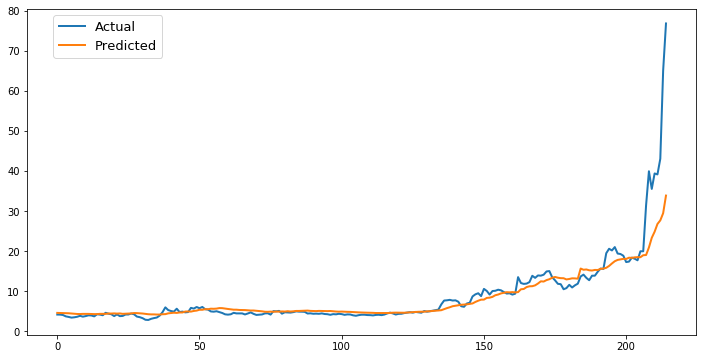

In [50]:
plt.figure(figsize = (12,6))
plt.plot(result_df["Actual_Y"],linewidth=2.0,label = "Actual")
plt.plot(result_df["Predicted_Y"],linewidth=2.0, label = "Predicted")
plt.rcParams.update({'font.size': 13})
plt.legend(loc="upper left", bbox_to_anchor=(0.03,1))
plt.show()